In [23]:
import git
from pathlib import Path
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
import cv2
import warnings
warnings.filterwarnings("ignore")

from collections import defaultdict
import re
import pickle

In [24]:
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)

DATASET = "coco"
FINAL_DATA_NAME = 'coco-indoor-learned'

data_dir = os.path.join(ROOT_DIR, 'raw-data', DATASET, "coco-indoor-cropped-sample")

In [25]:
np.random.seed(0)

# Load pretrained AlexNet
alexnet = torchvision.models.alexnet(pretrained=True)
alexnet.eval()  # set to evaluation mode

# Extract the first convolutional layer filters
first_conv = alexnet.features[0]
filters = first_conv.weight.data.clone().cpu().numpy()  # shape: [out_channels, in_channels, height, width]

filter_groups = {
    "single_edge": [3, 6, 10, 11, 12, 13, 14, 23, 24, 28, 29, 30, 32, 34, 43, 48, 49, 50, 55, 57], #gabor-like / edge detector
    "multi_edge": [9, 16, 18, 22, 25, 27, 33, 41, 54, 63], #complex gabor / complex edge detector
    "eye": [21, 31, 37, 39, 45, 46,], # color contrast
    "dual_color": [0, 2, 4, 5, 17, 20, 26, 38, 42, 44, 47, 56, 59], # color contrast
    "inside_out": [7, 15, 19, 35, 40, 51, 52, 53, 58], # smoothing
    "misc": [1, 8, 36, 60, 61, 62] # misc
}

In [26]:
def apply_learned_filters(image, filters, device='cpu'):
    """
    image: a numpy array of shape (H, W, 3) in range [0, 255] or normalized appropriately.
    filters: numpy array of shape (num_filters, in_channels, kH, kW).
    Returns: list of feature maps (one per filter).
    """
    # Convert image to a tensor and add batch dimension: shape [1, 3, H, W]
    # Assume image is in HxWxC format and normalized [0,1].
    transform = transforms.ToTensor()  # converts to range [0, 1] and shape (C, H, W)
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Convert filters to torch tensor and place on the same device.
    filter_tensor = torch.tensor(filters, dtype=torch.float32).to(device)
    
    # Convolve the image with all filters.
    feature_maps = F.conv2d(image_tensor, filter_tensor, bias=None, stride=1, padding=first_conv.padding)
    
    # feature_maps shape: [1, num_filters, H_out, W_out]
    return feature_maps.squeeze(0).cpu().detach().numpy()  # shape: (num_filters, H_out, W_out)

def apply_learned_filters_batch(images, filters, device='cpu'):
    """
    images: NumPy array of shape (N, H, W, 3) or list of images in HWC format, dtype float32 or uint8.
    filters: NumPy array of shape (num_filters, in_channels, kH, kW).
    Returns: torch tensor of shape (N, num_filters, H_out, W_out)
    """
    # Convert to torch tensor: shape (N, C, H, W)
    images = torch.stack([transforms.ToTensor()(img) for img in images])  # (N, 3, H, W)
    images = images.to(device)

    # Convert filters to tensor
    filter_tensor = torch.tensor(filters, dtype=torch.float32).to(device)

    # Run batch convolution (groups=1, so apply all filters to each image)
    feature_maps = F.conv2d(images, filter_tensor, bias=None, stride=1, padding='same')  # or customize padding

    return feature_maps.cpu().detach()  # shape: (N, num_filters, H_out, W_out)


def load_images_from_directory(directory, n=None, pastis=False):
    """
    Loads images from a directory.
    """
    if not n:
        n = len(os.listdir(directory))
    images = []
    for filename in os.listdir(directory)[:n]:
        if pastis:
            img = np.load(os.path.join(directory, filename))["image"].astype(np.float32)
        else:
            img = cv2.imread(os.path.join(directory, filename))
        images.append(img)
    return np.array(images)

def transform_images(images, filters, device='cpu'):
    """
    images: list or np.array of (N, H, W, 3)
    filters: numpy array of shape (num_filters, in_channels, kH, kW)
    """
    # Apply filters in batch
    feature_maps = apply_learned_filters_batch(images, filters, device)  # (N, num_filters, H_out, W_out)

    # Flatten per-filter results across all images
    num_filters = feature_maps.shape[1]
    feature_maps = feature_maps.permute(1, 0, 2, 3)  # (num_filters, N, H_out, W_out)
    flattened = feature_maps.reshape(num_filters, -1)  # Each row: all outputs of one filter

    return flattened.numpy()  # shape: (num_filters, total_pixels_across_all_images)

def bootstrap_skew(data, n_bootstrap=10000, sample_size=20000):
    # From each filter distribution of around 600k coefficients, take a random sample of sample_size, and then bootstrap n_bootsrap times
    """Bootstrap the skewness of the data to compute a confidence interval."""
    if len(data) > sample_size:
        data = np.random.choice(data, size=sample_size, replace=False)  # Downsample
    bootstrapped_skews = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_skews.append(skew(sample))
    return np.percentile(bootstrapped_skews, [2.5, 97.5])

def run_skew_test_with_filters(all_group_coef, filter_groups, filters, n_bootstrap=10000, sample_size=20000):
    skewed_data = []
    nonskewed_data = []
    skewed_groups = [] 
    nonskewed_groups = []
    skewed_indices = [] # Alex Indices
    nonskewed_indices = []

    for group in all_group_coef.keys():
        for i in range(len(all_group_coef[group])):
            coefficients = all_group_coef[group][i].flatten()
            ci = bootstrap_skew(coefficients, n_bootstrap=n_bootstrap, sample_size=sample_size)

            # Test if 0 is outside the CI
            if ci[0] > 0 or ci[1] < 0:
                skewed_data.append(coefficients)
                skewed_groups.append(group)
                skewed_indices.append(filter_groups[group][i])
            else:
                nonskewed_data.append(coefficients)
                #nonskewed_labels.append(f'{label}, CI: [{ci[0]:.3f}, {ci[1]:.3f}]')
                nonskewed_groups.append(group)
                nonskewed_indices.append(filter_groups[group][i])

    return skewed_data, nonskewed_data, skewed_groups, nonskewed_groups, skewed_indices, nonskewed_indices

In [27]:
images = load_images_from_directory(data_dir)
filter_groups_coef = {
    key: filters[val] for key, val in filter_groups.items()
}

group_transform_coef = {group: transform_images(images, filter_groups_coef[group]) for group in filter_groups_coef.keys()}

skewed_data, nonskewed_data, skewed_groups, nonskewed_groups, skewed_indices, nonskewed_indices = run_skew_test_with_filters(
    group_transform_coef, filter_groups, filters, n_bootstrap=100, sample_size=200)

In [ ]:
selected_filter_groups = {
    "single_edge": [3, 6, 10, 11, 12, 13, 14, 23, 24, 28, 29, 30, 32, 34, 43, 48, 49, 50, 55, 57], #gabor-like / edge detector
    "multi_edge": [9, 16, 18, 22, 25, 27, 33, 41, 54, 63], #complex gabor / complex edge detector
    "eye": [21, 31, 37, 39, 45, 46,], # color contrast
    "dual_color": [0, 2, 4, 5, 17, 20, 26, 38, 42, 44, 47, 56, 59], # color contrast
    "inside_out": [7, 15, 19, 35, 40, 51, 52, 53, 58], # smoothing
    "misc": [1, 8, 36, 60, 61, 62] # misc
}

In [52]:
nonskewed_indices

[3,
 6,
 10,
 11,
 12,
 13,
 14,
 23,
 24,
 28,
 29,
 30,
 34,
 48,
 49,
 50,
 55,
 57,
 9,
 16,
 18,
 22,
 27,
 33,
 41,
 54,
 63,
 21,
 31,
 37,
 39,
 45,
 46,
 0,
 2,
 4,
 5,
 17,
 20,
 26,
 38,
 42,
 59,
 7,
 15,
 53,
 1,
 60,
 61,
 62]

In [28]:
# Skew Test Summary

total_filters = {group: len(filters) for group, filters in filter_groups.items()}

passed_counts = defaultdict(int)
for group in nonskewed_groups:
    passed_counts[group] += 1

summary = []
for group in total_filters:
    total = total_filters[group]
    passed = passed_counts.get(group, 0)
    failed = total - passed
    summary.append((group, total, passed, failed))

summary_df = pd.DataFrame(summary, columns=[
    "group", "total_filters", "passed_skew_test", "failed_skew_test"
])

summary_df = summary_df.drop(columns=["failed_skew_test"])

summary_df["proportion_passed"] = np.round(summary_df["passed_skew_test"] / summary_df["total_filters"], 3)

# Calculate sums for each numeric column
summary_totals = summary_df[["total_filters", "passed_skew_test"]].sum()

# Create new row with label 'all' and the totals
all_row = pd.DataFrame([{
    "group": "all",
    "total_filters": summary_totals["total_filters"],
    "passed_skew_test": summary_totals["passed_skew_test"],
    "proportion_passed": np.round(summary_totals["passed_skew_test"] / summary_totals["total_filters"], 3)
}])

# Append to the summary DataFrame
summary_df_with_total = pd.concat([summary_df, all_row], ignore_index=True)

# Display the updated DataFrame
summary_df_with_total

,group,total_filters,passed_skew_test,proportion_passed
0,single_edge,20,18,0.900
1,multi_edge,10,9,0.900
2,eye,6,6,1.000
3,dual_color,13,10,0.769
4,inside_out,9,3,0.333
5,misc,6,4,0.667
6,all,64,50,0.781


# Saving Data

In [29]:
data_output_file = os.path.join(ROOT_DIR, 'transformed-data', FINAL_DATA_NAME) + ".pickle"
size_output_file = os.path.join(ROOT_DIR, 'transformed-data', FINAL_DATA_NAME + "-size") + ".pickle"

In [30]:
rows = []

for i in range(len(nonskewed_data)):
    group = nonskewed_groups[i]
    alex_idx = nonskewed_indices[i]
    id_in_group = filter_groups[group].index(alex_idx) if alex_idx in filter_groups[group] else None
    coefs = group_transform_coef[group][id_in_group]
    rows.append({
        'alex_idx': alex_idx,
        'group': group,
        'group_idx': id_in_group,
        'data': coefs
    })

df = pd.DataFrame(rows)
df.head()

,alex_idx,group,group_idx,data
0,3,single_edge,0,"[-2.1419616, -2.7094438, -3.086709, -3.3516068..."
1,6,single_edge,1,"[1.0425489, 0.28231156, -0.2493894, -0.3219636..."
2,10,single_edge,2,"[0.92339087, 1.2905043, 1.584868, 1.7377465, 1..."
3,11,single_edge,3,"[-0.8270185, -0.18306199, 0.19829085, 0.186523..."
4,12,single_edge,4,"[-1.1930954, 0.69922334, 2.050966, 0.5888305, ..."


In [31]:
df["data"][0].shape

(1835008,)

In [32]:
group_size_counts = df['data'].apply(len)
size_df = df.copy().drop(columns = ['data'])
size_df['size'] = group_size_counts
size_df.head()

,alex_idx,group,group_idx,size
0,3,single_edge,0,1835008
1,6,single_edge,1,1835008
2,10,single_edge,2,1835008
3,11,single_edge,3,1835008
4,12,single_edge,4,1835008


In [33]:
# Save the nonskewed_data to a pickle file
with open(data_output_file, "wb") as f:
    pickle.dump(df, f)

print(f"coefficient data has been saved to {data_output_file}")

with open(size_output_file, "wb") as f:
    pickle.dump(size_df, f)

print(f"size data has been saved to {size_output_file}")

coefficient data has been saved to c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\transformed-data\coco-indoor-learned.pickle
size data has been saved to c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\transformed-data\coco-indoor-learned-size.pickle


In [49]:
images.shape

(28, 256, 256, 3)

In [51]:
28*256*256

1835008

<Axes: ylabel='Count'>

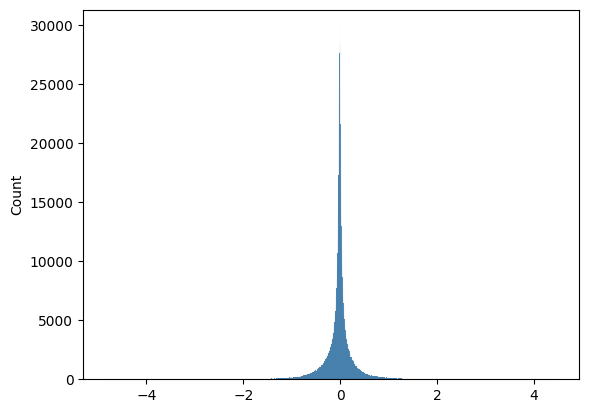

In [ ]:
sns.histplot(df.loc[1]['data'])

